In [1]:
import requests
from pprint import pprint
import os
import subprocess
import boto3
from bravado.requests_client import RequestsClient
from bravado.client import SwaggerClient
import folium
import rasterio
from rasterio.plot import show, show_hist
from matplotlib import pyplot as plt
import datetime
import time
import json
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import shapely
import cartopy
import copy
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# while useful, the python bindings for gdal don't yet include
# its full functionality. Run gdal from the command line or
# use "!gdalinfo [args] (or whichever cli gdal command you like)
# to run commands from the notebook
from osgeo import gdal

## Inputs 
Use the Radiant Earth Foundation web [app](https://app.radiant.earth/user/me/settings/api-tokens) to generate an API refresh token, and insert it in the following block. 

In [2]:
api_refresh_token=''

aws_access_key_id = ''

aws_secret_access_key = ''


## Genarating your API key

Radiant's platform uses a refresh-session token system to connect to the backend. Session tokens are ephemeral (they expire), so we can use a Swagger Client object to generate a persistent API key.

In [3]:
def generate_api_key(refresh_token):
    """
    Use the refresh token created at
    https://app.radiant.earth/user/me/settings/api-tokens
    to generate an API token.
    """

    http_client = RequestsClient()

    spec_url = 'https://raw.githubusercontent.com/radiantearth/radiantearth-python-client/dev/radiantearth/spec.yml'

    config = {'validate_responses': False}
    client = SwaggerClient.from_url(spec_url, http_client=http_client, config=config)
    post_body = {'refresh_token': refresh_token}
    api_key = client.Authentication.post_tokens(
                    refreshToken=post_body).future.result().json()['id_token']
    
    return api_key

In [4]:
api_key = generate_api_key(api_refresh_token)

base_url = "https://api.radiant.earth/platform/"

headers = {"Authorization": api_key,
          "Accept": "application/json"}

Great! now that we have an API key, let's look at the imagery we put in the mounted, `workdir/` directory. `find_files()` searches `workdir/` and any subdirectories you may have made when copying imagery.

**Note:** As a best practice, it is recommended to use unique, easily-identifiable filenames, for example including name of location and date of acquisition.

In [5]:
def find_files(ftype='TIF'):
    """
    Returns list of .tif filepaths  in /workdir or its subdirectories
    """
    f = []
            
    for (dirpath, dirnames, filenames) in os.walk("/workdir"):
        tifs = [dirpath+"/"+filename for filename in filenames if filename[-len(ftype):] == ftype or filename[-len(ftype):] == ftype.lower()]
        f.extend(tifs)
    
    return f

In [6]:
files = find_files()
print(files)

['/workdir/data/HHNorthExport.tif', '/workdir/data/HHNorthExport-corrected.tif', '/workdir/data/HighlandHouse2018_UTM20.tif', '/workdir/data/HighlandHouse2018_UTM20-corrected.tif']


## Inspecting the data

*Note - GDAL's [python documentation](https://gdal.org/python/) (althouth [this](https://pcjericks.github.io/py-gdalogr-cookbook/) is an useful resource) can be somewhat confusing. Thus throughout this tutorial we'll cover some command line examples as well as the Python library.*

Often when working with geospatial data, it can be useful to glance over a readout of the details of your file. GDAL - the Geospatitial Data Abstraction Library – is a great command line utility and python library to do this. In a Jupyter Notebook, we can easily execute a shell command by using `!`. Here's an example:

In [7]:
!gdalinfo /workdir/data/HHNorthExport.tif

Driver: GTiff/GeoTIFF
Files: /workdir/data/HHNorthExport.tif
       /workdir/data/HHNorthExport.tif.ovr
       /workdir/data/HHNorthExport.tif.aux.xml
Size is 16259, 15856
Coordinate System is:
PROJCS["WGS_1984_UTM_Zone_20N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-63],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","32620"]]
Origin = (628145.696407759096473,1953802.347225968260318)
Pixel Size = (0.016722087614756,-0.016030999440613)
Metadata:
  AREA_OR_POINT=Area
  DataType=Generic
Image St

Hmmm, the undefined fourth band is looking interesting, especially considering this is RGB drone data. Let's take a look at our other file.

In [8]:
!gdalinfo /workdir/data/HighlandHouse2018_UTM20.tif

Driver: GTiff/GeoTIFF
Files: /workdir/data/HighlandHouse2018_UTM20.tif
       /workdir/data/HighlandHouse2018_UTM20.tif.ovr
       /workdir/data/HighlandHouse2018_UTM20.tif.aux.xml
Size is 9626, 9993
Coordinate System is:
PROJCS["WGS_1984_UTM_Zone_20N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-63],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","32620"]]
Origin = (628174.481451906845905,1953795.088881077943370)
Pixel Size = (0.028974523848047,-0.027776978961205)
Metadata:
  AREA_OR_POINT=Area

Again, seeing that mysterious undefined fourth band made of zeros. Hmmm...

Geospatial engineering fact of life: This stuff is **complex**. Sometimes there are unexpected bugs when we're doing photogammetric processing ([here's a great free tool](https://www.opendronemap.org/) if you are looking to make a geotiff out of your drone data), sometimes we make a mistake and forget to click the right settings box in QGIS or ArcGIS. As engineers we need to do our best to write fault-tolerant code and assume that imperfect data will be coming down the pipeline at some point.

So, how do we remove the empty fourth band?

In [9]:
# method 1: use GDAL shell utility to create a new file with the specified bands

# example-
# gdal_translate -b 1 -b 2 -b 3 input.tif output.tif

# our code-
!gdal_translate -b 1 -b 2 -b 3 /workdir/data/HighlandHouse2018_UTM20.tif /workdir/data/HighlandHouse2018_UTM20-corrected.tif

Input file size is 9626, 9993
0...10...20...30...40...50...60...70...80...90...100 - done.


In [10]:
# method 2: use GDAL python library to open the file and do the same operation

original = "/workdir/data/HHNorthExport.tif"
corrected = "/workdir/data/HHNorthExport-corrected.tif"

f = gdal.Open(original)

gdal.Translate(srcDS=f, destName=corrected, bandList=(1,2,3))

# These are large files. While python garbage collection will generally take care of this,
# it can be a good precaution to manually overwrite variables to free up memory.
f = None

## Visualizing imagery in Jupyter Notebook

Depending on your workflow, it can at times be useful to visualize data in a jupyter notebook. This can be especially true if you're working to build a custom classification model. Here are two ways to render geospatial data in this environment.

In [11]:
# show filepaths again
find_files()

['/workdir/data/HHNorthExport.tif',
 '/workdir/data/HHNorthExport-corrected.tif',
 '/workdir/data/HighlandHouse2018_UTM20.tif',
 '/workdir/data/HighlandHouse2018_UTM20-corrected.tif']

In [12]:
# method 1: use rasterio to open the data and render

def rasterio_render(filepath):
    """
    Loads a geotiff and renders selected bands.
    More rasterio examples at 
    https://rasterio.readthedocs.io/en/latest/topics/plotting.html
    """
    with rasterio.open(filepath) as src:
        show(src,  plt.subplots(figsize=[10,10], ncols=1))

Note: The following visualization might cause your Kernel to crash. 

In [ ]:
rasterio_render('/workdir/data/HHNorthExport-corrected.tif')

### A note of caution:

Geospatial data is heavy. In particular, loading and rendering geospatial data requires a lot of memory that can sometimes cause your computer / Jupyter Notebook kernel to crash. If you want to render several large files at once, we recommend you upload your data to the Radiant platform, where we distribute all computational work across a cluster of powerful servers to take the load off of your machine. Plus, it's free :)

## Upload data to Radiant Earth Platform

Uploading to the Radiant earth platform via API consists of several steps.

- Create a project or select an existing project (not required).

- Select a [datasource](https://help.radiant.earth/basic-resource-guide/data/managing-datasources) for your data. Selecting or creating a datasource for your upload data is necessary in order for the platform to display and process your data.

- Verify that the number of bands in your data match the number of bands in the datasource type you are marking it as.

- Use the Boto 3 package and our AWS user `radiant-upload-temp-user` to upload your files to Amazon S3. If you have entered a `aws_access_key_id` and `aws_secret_access_key` at the begining of the code, the following block with write that in the `~/.aws/credentials` file.


Note: All data placed in this bucket is ephemeral and will be deleted shortly after the upload to the Radiant Earth Platform is complete.

- Send a post request to `/uploads` that tells the platform to pull your data out of S3, assign a datasource type to it, assign it to a project, and begin the ingestions process.

**Note:**
Alternatively, if you already have your own S3 bucket that you'd like to upload data from, add the policy [here](https://help.radiant.earth/developer-resources/share-amazon-s3-bucket-with-radiantearth) to allow Radiant's platform to ingest directly.

In [13]:
def write_aws_cred(aws_access_key_id, aws_secret_access_key):
    filename = '/root/.aws/credentials'
    with open(filename, 'w+') as out:
        out.write("[default]" + '\n')
        out.write("aws_access_key_id = " + aws_access_key_id + '\n')
        out.write("aws_secret_access_key = " + aws_secret_access_key + '\n')

In [14]:
write_aws_cred(aws_access_key_id, aws_secret_access_key)

In [15]:
def create_project(name, description="", visibility="PRIVATE", tileVisibility="PRIVATE", isAOIProject=False, tags=[]):
    """
    Creates a new project
    
    name is a string defining the project's name
    description is a string containing a breif description of your project
    visibility can be PRIVATE (only accessible to you) or PUBLIC (accessible to everyone on the platform)
    tileVisibility can be PRIVATE (only accessible to you or others whom you share a mapToken with) or PUBLIC (accessible to everyone)
    tags is an array of strings 
    isAOIProject is a boolean variables (True or False) that specifies if a project is Standard (False) or AOI (True).
                 AOI Project is used to actively monitor if a new scene is available over your area of interest.
    """
    
    params = {"name": name, 
              "description": description, 
              "visibility": visibility, 
              "tileVisibility": tileVisibility, 
              "tags": tags, 
              "isAOIProject": isAOIProject 
             }
    
    r = requests.post(url=base_url+"projects/", headers=headers, json=params)
    
    return r.json()

In [16]:
def search_datasources(query=""):
    """
    Search for a specific datasource or use default arg to retrieve
    all datasources accesssible to your account (custom and generic datasources)
    """
    
    params = {"search":query}
    r = requests.get(url=base_url+"datasources/", headers=headers, params=params)
    
    return r.json()['results']

In [17]:
def verify_datasource(all_ds_info=False):
    """
    Searches datasource by name and returns datasource ID.
    Prompts for verification if no results or more than one result.
    """
    
    ds = search_datasources()
    ds_ids = {x['name'].lower(): x['id'] for x in ds}
    print("Available datasource types:")

    if all_ds_info:
        print("Displaying complete datsource type info: ")
        pprint(ds)
    else:
        pprint({x['name']: 'num_bands = {}'.format(len(x['bands'])) for x in ds})

    while True:

        ds_type = input("Datasource type of your data: ").lower()
        datasource_results = search_datasources(query=ds_type)

        if len(datasource_results) == 0:
            print("Datasource type not found")

        elif len(datasource_results) > 1:
            names = [x["name"] for x in datasource_results]
            
            # need extra verification b/c 2 datasource types returned
            if ds_type == "worldview 2":
                verify = input("Verification needed. Please enter exact WorldView 2 datasource type: {} ".format(names))
                return ds_ids[verify.lower()]
            else:
                print("Multiple datasource results found. Enter exact datasource type name: {}".format(names))

        else:
            return datasource_results[0]['id']

In [18]:
def get_ds_bands(ds_id):
    """
    Takes a datasource type ID and returns bands info.
    """
    r = requests.get(url=base_url+"datasources/"+str(ds_id), headers=headers)
    
    return r.json()['bands']

In [19]:
def get_ds_band_count(ds_id):
    """
    Takes a datasource type ID and returns number of bands.
    """
    r = requests.get(url=base_url+"datasources/"+str(ds_id), headers=headers)
    
    return len(r.json()['bands'])

In [20]:
def get_aquisition_date():
    
    isValid=False
    while not isValid:
        userIn = input("Enter aquisition date yyyy-mm-dd: ")
        
        try: # strptime throws an exception if the input doesn't match the pattern
            d = datetime.datetime.strptime(userIn, "%Y-%m-%d")
            d = d.isoformat()+".000Z"
            isValid = True
            
        except:
            print("Invalid datetime, try again.\n")
            
    return d

In [21]:
def get_cloud_cover():
    
    isValid=False
    while not isValid:
        userIn = float(input("Enter cloud cover percentage from 0-100 to 2 decimals. Ex: 61.12 or 0 or 13.2: "))
        
        try:
            0<=userIn<=100
            isValid = True
        
        except:
            print("Invalid cloud cover percentage, try again.\n")
    
    cloudcover = float("{0:.2f}".format(userIn))
    
    return cloudcover

In [22]:
def gen_metadata():
    """
    Returns dictionary of cloud cover percentage and aquisition date.
    """
    cloudCover = get_cloud_cover()
    aquisitionDate = get_aquisition_date()

    metadata = {"cloudCover": cloudCover,
                "acquisitionDate": aquisitionDate}
    
    return metadata

In [31]:
def verify_upload(files, ds_id):
    """
    Verifies each file for upload. ds_name is a platform 
    datasource name - "WorldView 3", for example.
    """
    
    expected_band_count = get_ds_band_count(ds_id)
    
    to_upload = []
    for file in files:        
        src_ds = gdal.Open("{}".format(file))
        if src_ds is not None: 
            print("file: "+file)
            band_count = src_ds.RasterCount
            print("band count: " + str(band_count))
            if band_count != expected_band_count:
                print("Warning, file band count ({}) does not equal expected datasource band count ({})!".format(band_count, expected_band_count))
                print("This could result in unexpected platform behavior.")
                if input("Remove file from upload? [y/n] ").lower() != "n":
                    print("{} skipped.".format(file))
                    #return None
            else:
                print("Band count ({}) equals expected datasource band count ({}) :)".format(band_count, expected_band_count))
                to_upload.append(file)
        
        # free up memory
        src_ds = None
    
    return to_upload

In [32]:
def upload_s3(files):

    s3 = boto3.resource('s3')
    bucket = s3.Bucket('radiant-upload-temp')

    # check to see if file is already in bucket
    bucket_objects = [x.key for x in bucket.objects.all()]
    
    uploaded = []
    for file in files:
        filename = file.split("/")[-1]
        

        if filename in bucket_objects:
            print("{} already exists in radiant-upload-temp.".format(filename))
            print("A new upload (response = 'n') will overwrite the existing file in S3")
            upload = input("Skip to next file and proceed to platform ingestion? [y/n] ")
            if upload == "y":
                uploaded.append(filename)
                continue
            else:
                print("Continuing upload and writing over {}.".format(filename))    
        
        print("Uploading {}. This may take some time...".format(filename))
        data = open(file, 'rb')
        bucket.put_object(Key=filename, Body=data)
        
        uploaded.append(filename)
        print("{} succesfully uploaded to S3.".format(filename))
    
    return uploaded

In [33]:
def create_upload(files, datasource, metadata, project_id, visibility="PRIVATE"):
    """
    Initiating upload of a scene or list of scenes. 
    
    files is an array of strings containing the path to each file
    datasource is a string specifying datasource ID
    fileType should be set to "GEOTIFF" that is the only supported formatat this time
    visibility can be PRIVATE (only accessible to you) or PUBLIC (accessible to everyone on the platform)
    uploadType should be set to S3" which is the only supported format at this time
    metadata is a dictionary of all the metadata related to the scene (such as cloudcover, date of acquisition)
    source is set to null" (pass this exactly, python's `None` will fail)
    projectId is a string with project ID if you want to add the scene to a project after upload
    uploadStatus is a string and should be set to "UPLOADED" for platform to begin ingest process
    """
    
    params = {"files":files,
              "datasource":datasource,
              "fileType":"GEOTIFF",
              "visibility":visibility, 
              "uploadType":"S3",  
              "metadata":metadata,
              "source": "null", 
              "projectId": project_id,
              "uploadStatus": "UPLOADED" 
             }
    
    r = requests.post(url=base_url+"uploads/", headers=headers, json=params)
    
    return r

In [39]:
def create_project_upload_all(name, **kwargs):
    
    # Create a project
    project_id = create_project(name=name)['id']
    print("project id = " + project_id)
    # Display available datasources and prompt for selection    
    ds_id = verify_datasource()
    print(ds_id)   
    # search for uploadable files
    files = find_files()
    
    # verify upload files
    to_upload = verify_upload(files, ds_id)
    
    # upload to S3
    uploaded = upload_s3(to_upload)
    print(uploaded)
    
    sent_to_platform = []
    
    for file in uploaded:
        
        print(file.split("/")[-1])
        # generate metadata for specific image
        metadata = gen_metadata()
        print(metadata)
        # ingest into Radiant platform
        r  = create_upload(files=["s3://radiant-upload-temp/"+file], datasource=ds_id, project_id=project_id, metadata=metadata)
        sent_to_platform.append(r.json())
        
    return sent_to_platform
    

In [35]:
def get_upload_details(uuid):
    """
    Get upload status for a given upload.
    'UPLOADED' meaning the upload and ingestion process has been initiated
    'PROCESSING'
    'COMPLETE'
    'FAILED'
    """
    r = requests.get(url=base_url+"uploads/"+str(uuid), headers=headers)
    return r.json()

In [36]:
def upload_runner(name, **kwargs):
    
    uploads = create_project_upload_all(name=name, **kwargs)
    
    total = len(uploads)
    complete = 0
    failed = 0
    done = False
    
    while not done:
        for upload in uploads:
            status = get_upload_details(upload['id'])['uploadStatus']
            
            filename = upload['files'][0].split("/")[-1]
            if status == 'COMPLETE':
                print("{} status = {}".format(filename, status.lower()))
                complete += 1
                if (complete + failed) == total:
                    return "Upload process complete. {} uploads failed and {} uploads succeeded.".format(failed, complete)
                
            elif status == 'FAILED':
                print("{} status = {}".format(filename, status.lower()))
                failed += 1
                if (complete + failed) == total:
                    return "Upload process complete. {} uploads failed and {} uploads succeeded.".format(failed, complete)
            else:
                print("{} status = processing".format(filename))
            
        time.sleep(30)
                    

In [37]:
# HighlandHouse2018_UTM20-corrected.tif: Acquisition date 2018-06-15
# HHNorthExport-corrected.tif: Acquisition date 2016-05-21
# Hurricane Irma was 378 miles wide and near the peak of its intensity as a Category 5 hurricane 
# when it made landfall and tore into the 62-square-mile island of Barbuda on the night of September 5 - 6.

In [40]:
upload_runner(name="barbuda_webinar")

project id = cb8ef4c2-8d5e-4462-9d27-382ada1ce9f5
Available datasource types:
{'4-band PlanetScope': 'num_bands = 4',
 'CCAP Historical AVHRR': 'num_bands = 26',
 'Generic': 'num_bands = 0',
 'GeoEye 1': 'num_bands = 5',
 'GeoEye 2': 'num_bands = 5',
 'IKONOS-2': 'num_bands = 5',
 'ISERV': 'num_bands = 3',
 'Landsat 4 + 5 Thematic Mapper (TM)': 'num_bands = 7',
 'Landsat 7 Enhanced Thematic Mapper Plus (ETM+)': 'num_bands = 9',
 'Landsat 8': 'num_bands = 11',
 'Landsat Tri-Decadal Multispectral Scanner (MSS)': 'num_bands = 4',
 'M0D09A1': 'num_bands = 13',
 'MYD09A1': 'num_bands = 13',
 'QuickBird': 'num_bands = 5',
 'RapidEye': 'num_bands = 5',
 'Sentinel-2': 'num_bands = 13',
 'UAV - 3 Band': 'num_bands = 3',
 'VT Orthos 2016': 'num_bands = 4',
 'Vision - RGB 3 Band': 'num_bands = 3',
 'WorldView 1': 'num_bands = 1',
 'WorldView 2': 'num_bands = 9',
 'WorldView 3': 'num_bands = 29',
 'Worldview 2 - 4 Band': 'num_bands = 4',
 'sequoia_4band': 'num_bands = 4'}
Datasource type of your d

'Upload process complete. 0 uploads failed and 2 uploads succeeded.'

In [41]:
find_files(ftype='geojson')

['/workdir/geojsons/ATG.geojson']

In [42]:
def load_geojson(geojson_filepath):
    """
    Open a geojson and return a geojson object.
    """
    with open(geojson_filepath) as f:
        geojson = json.load(f)
        
    return geojson

In [43]:
def create_shape(geojson, shape_name):
    """
    Takes a geojson object and name, uploads to platform.
    """
    
    payload = {'features': [geojson],
              'type': 'FeatureCollection'}
    
    # purge existing 'properties'
    payload['features'][0]['properties'] = {'name':shape_name}
    r = requests.post(url=base_url+"shapes", json=payload, headers=headers)
    
    return r.json()

In [44]:
def get_shapes():
    """
    Returns all shapes available to user.
    """
    
    r = requests.get(url=base_url+"shapes", headers=headers)
    
    return r.json()

In [45]:
def get_scenes(shape_id, datasource=[], minCloudCover=0, maxCloudCover=10, minAcquisitionDatetime="", maxAcquisitionDatetime="", **kwargs):
    """
    Get a list of scenes corresponding to datasource type, date, shape and cloudcover.
    
    [default args]
    datasource = list of datasource IDs (each ID is a string)
    shape = 'c2fae467-180b-483c-8666-dbbb25181023' (string of shape ID. Use create_shape() to upload shape to platform)
    maxCloudCover = 10 float percentage of cloud cover (0-100, eg 13.26 is valid)
    minAcquisitionDatetime = '2015-01-21T00:00:00.000Z' (string in iso 8601 format)
    maxAcquisitionDatetime = '2017-01-21T00:00:00.000Z' (string in iso 8601 format)
    
    [optional kwargs]
    bbox = -62.32131958007813,17.472502452750295,-61.60720825195313,17.746070780233786 (string)
    """
    
    params = {'shape': shape_id,
              'datasource': datasource,
              'minCloudCover': minCloudCover,
              'maxCloudCover': maxCloudCover,
              'minAcquisitionDatetime': minAcquisitionDatetime,
              'maxAcquisitionDatetime': maxAcquisitionDatetime}
    
    # add kwargs to params
    for key, value in kwargs.items():
        params[key] = value
        
    r = requests.get(url=base_url+"scenes", params=params, headers=headers)    
    
    return r.json()

In [46]:
def get_datasource_ids():
    """
    Get ids of all datasources
    Returns a dictionary of all available datasources to the user (both custom and public)
    """
    
    ds = search_datasources()
    ds_ids = {x['name'].lower(): x['id'] for x in ds}
    
    return ds_ids
    

In [47]:
ds_ids = get_datasource_ids()

In [48]:
ds_ids

{'4-band planetscope': 'e4d1b0a0-99ee-493d-8548-53df8e20d2aa',
 'ccap historical avhrr': '646e3842-c6d9-4c11-948d-16c6e8f27f7e',
 'generic': '866b22ee-e3e5-43e3-8ba0-d538249ab3b6',
 'geoeye 1': 'e068461d-a368-4def-92ae-e4c8cc8cb784',
 'geoeye 2': '2ee9dce4-8077-41d1-b37a-cf45a458ae3b',
 'ikonos-2': '2c6cde7e-3d69-41f2-b697-f58d1b09276c',
 'iserv': 'eb34ce6d-acf5-49a3-ae43-5b4480a3ff7a',
 'landsat 4 + 5 thematic mapper (tm)': 'e8c4d923-5a73-430d-8fe4-53bd6a12ce6a',
 'landsat 7 enhanced thematic mapper plus (etm+)': '5a462d31-5744-4ab9-9e80-5dbcb118f72f',
 'landsat 8': '697a0b91-b7a8-446e-842c-97cda155554d',
 'landsat tri-decadal multispectral scanner (mss)': 'b5d02569-11f7-473d-be82-d1d4e1ce45f3',
 'm0d09a1': 'a11b768b-d869-476e-a1ed-0ac3205ed761',
 'myd09a1': '55735945-9da5-47c3-8ae4-572b5e11205b',
 'quickbird': '9fd7fcf3-6175-4f29-b1b2-29b82fa84321',
 'rapideye': 'dd68e7eb-4055-4657-9cfb-bd82c0904f78',
 'sentinel-2': '4a50cb75-815d-4fe5-8bc1-144729ce5b42',
 'sequoia_4band': '1954f061-

In [49]:
find_files(ftype='geojson')

['/workdir/geojsons/ATG.geojson']

In [50]:
barbuda = load_geojson('/workdir/geojsons/ATG.geojson')

In [51]:
barbuda

{'geometry': {'coordinates': [[[[-61.773019985999916, 17.126532294000143],
     [-61.75641842399997, 17.11416250200001],
     [-61.75544186099989, 17.123032945000162],
     [-61.752756313999924, 17.128892320000105],
     [-61.74331620999991, 17.1415062520001],
     [-61.73761959499993, 17.13296133000007],
     [-61.72984778599994, 17.127997137000122],
     [-61.72008216099987, 17.1263695330001],
     [-61.70860755099994, 17.127834377000152],
     [-61.71349036399992, 17.12254466400016],
     [-61.716297980999855, 17.118801174000126],
     [-61.720529751999976, 17.11611562700007],
     [-61.729644334999875, 17.11416250200001],
     [-61.72508704299992, 17.09983958500014],
     [-61.714833136999914, 17.09308502800009],
     [-61.70164954299986, 17.093451239000032],
     [-61.688099738999874, 17.100531317000062],
     [-61.6806534499999, 17.100531317000062],
     [-61.67552649599989, 17.095607815],
     [-61.67210852799988, 17.090643622000144],
     [-61.66759192599994, 17.079413153000147

In [52]:
barbuda_shape_id = create_shape(barbuda, "Barbuda")[0]['id']

In [53]:
barbuda_shape_id

'2f8c3181-16c5-4674-b491-5d9ea133c65d'

In [54]:
# 2018-10-24
maxdate = get_aquisition_date()

Enter aquisition date yyyy-mm-dd: 2018-10-24


In [55]:
# 2018-07-24
mindate = get_aquisition_date()

Enter aquisition date yyyy-mm-dd: 2018-07-24


In [56]:
scenes = get_scenes(shape_id=barbuda_shape_id,
                    datasource=['4a50cb75-815d-4fe5-8bc1-144729ce5b42'], 
                    minAcquisitionDatetime=mindate,
                    maxAcquisitionDatetime=maxdate)

In [57]:
scenes

{'count': 9,
 'hasNext': False,
 'hasPrevious': False,
 'page': 0,
 'pageSize': 30,
 'results': [{'createdAt': '2018-10-20T07:18:07.181Z',
   'createdBy': 'auth0|5a0f370f78914308349ac6dd',
   'dataFootprint': {'coordinates': [[[[-62.06448197508578, 16.19037106111459],
       [-62.05964144364202, 17.182791762213967],
       [-61.027486040812065, 17.175340777437558],
       [-61.03763348070667, 16.183374048814766],
       [-62.06448197508578, 16.19037106111459]]]],
    'type': 'MultiPolygon'},
   'datasource': {'bands': [{'name': 'Coastal Aerosol',
      'number': '1',
      'wavelength': 0.443},
     {'name': 'Blue', 'number': '2', 'wavelength': 0.49},
     {'name': 'Green', 'number': '3', 'wavelength': 0.56},
     {'name': 'Red', 'number': '4', 'wavelength': 0.665},
     {'name': 'Red Edge 1', 'number': '5', 'wavelength': 0.705},
     {'name': 'Red Edge 2', 'number': '6', 'wavelength': 0.74},
     {'name': 'Red Edge 3', 'number': '7', 'wavelength': 0.783},
     {'name': 'Near Infrared'

In [58]:
def visualize(geojson, scene, zoom_level=0.2):
    """
    Renders footprints of AOI and scene
    """

    # both of these are identical in structure
    aoi = copy.deepcopy(geojson['geometry'])
    scene_boundary = scene['dataFootprint']

    # grab a corner from aoi polygon
    corner = aoi['coordinates'][1][0][0]
    albers = cartopy.crs.AlbersEqualArea(central_latitude=corner[1], central_longitude=corner[0])
    lonlat_crs = cartopy.crs.PlateCarree()

    fig = plt.figure(figsize=(6, 8))

    # specify projection of the map
    ax = plt.subplot(projection=albers)

    # add aoi
    aoi_test = shapely.geometry.shape(aoi)
    scene_test = shapely.geometry.shape(scene_boundary)

    # add scene and aoi geometries to plot
    ax.add_geometries([shapely.geometry.shape(aoi)], lonlat_crs, alpha=0.5, color='blue')
    ax.add_geometries([shapely.geometry.shape(scene_boundary)], lonlat_crs, alpha=0.1, color='green')


    scene_polygon = Polygon(scene_boundary['coordinates'][0][0])

    # capture all aoi objects (in case of polygon = multiple, for example)        
    aoi_polygon_objects = [Polygon(x[0]) for x in aoi['coordinates']]
    aoi_polygon_objects.extend([scene_polygon])

    # create a combined polygon to ensure both aoi and scene footprints are displayed
    combined_polygon = cascaded_union(aoi_polygon_objects)

    combined_bbox = combined_polygon.bounds
    combined_extent = (combined_bbox[0], combined_bbox[2], combined_bbox[1], combined_bbox[3])

    # zoom out slightly beyond edge of aoi and scene polygons
    zoom = (-zoom_level, zoom_level, -zoom_level, zoom_level)
    combined_extent_zoom = [sum(x) for x in zip(combined_extent, zoom)]

    # set boundaries of plot
    ax.set_extent(combined_extent_zoom, crs=lonlat_crs)
    ax.gridlines(crs=lonlat_crs)

    datasource_name = scene['datasource']['name']
    cloud_cover = scene['sceneMetadata']['cloudyPixelPercentage']
    acquisition_date = scene['sceneMetadata']['timeStamp']
    scene_id = scene['id']

    print(datasource_name)
    print("Acquisition date = {}".format(acquisition_date))
    print("Cloud cover percentage = {}".format(cloud_cover))
    print("Scene ID = {}".format(scene_id))

    plt.title('{}'.format(scene_id))
    plt.show()

Sentinel-2
Acquisition date = 2018-10-19T14:47:28.462Z
Cloud cover percentage = 4.46
Scene ID = 85f50b3b-c5fe-42e2-b4d4-a51289f1fb8f


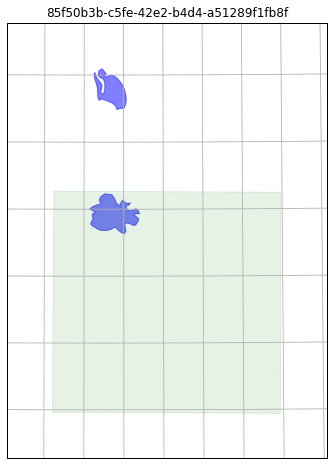

Sentinel-2
Acquisition date = 2018-10-19T14:47:28.462Z
Cloud cover percentage = 2.57
Scene ID = 00939e97-4979-4ef0-942e-6cd6e9fa547b


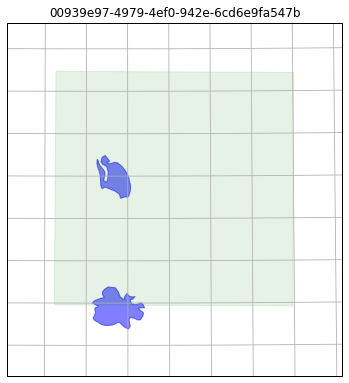

Sentinel-2
Acquisition date = 2018-09-24T14:47:26.461Z
Cloud cover percentage = 5.39
Scene ID = 76aa5d95-7c13-4ce4-a831-8936211f5aa0


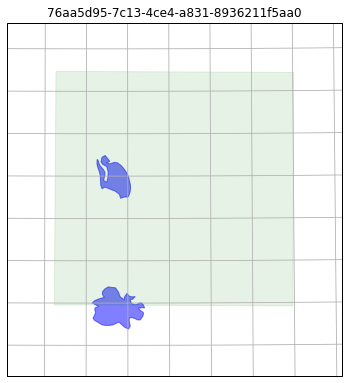

In [59]:
for scene in scenes['results'][:3]:
    visualize(barbuda, scene)

## Create a new project
Projects are datasource type-specific, so in order to look at Barbuda with Sentinel-2 data, we'll create a new project.

In [61]:
create_project(name='Barbuda Sentinel-2 Webinar')

{'aoiCadenceMillis': 604800000,
 'aoisLastChecked': '2018-10-25T02:09:54.370Z',
 'createdAt': '2018-10-25T02:09:54.370Z',
 'createdBy': 'oauth2|RadiantEarth|auth0|5b3507ac7ddc051b6f8ff337',
 'defaultAnnotationGroup': None,
 'description': '',
 'extent': None,
 'extras': None,
 'id': '6f7b8575-c7ff-444f-a3d6-1066bb48c520',
 'isAOIProject': False,
 'isSingleBand': False,
 'manualOrder': True,
 'modifiedAt': '2018-10-25T02:09:54.370Z',
 'modifiedBy': 'oauth2|RadiantEarth|auth0|5b3507ac7ddc051b6f8ff337',
 'name': 'Barbuda Sentinel-2 Webinar',
 'owner': 'oauth2|RadiantEarth|auth0|5b3507ac7ddc051b6f8ff337',
 'singleBandOptions': None,
 'slugLabel': 'Barbuda Sentinel-2 Webinar',
 'tags': [],
 'tileVisibility': 'PRIVATE',
 'visibility': 'PRIVATE'}

In [62]:
def add_scene(project_id, scene_ids=[]):
    """"
    project_id = string of project ID
    scene_ids = list/array of scene ID strings
    """
    payload = scene_ids
    
    r = requests.post(url=base_url+"projects/{}/scenes/".format(project_id), json=payload, headers=headers)
    
    return r.json()

In [64]:
r = add_scene(project_id='6f7b8575-c7ff-444f-a3d6-1066bb48c520', scene_ids=['00939e97-4979-4ef0-942e-6cd6e9fa547b', '85f50b3b-c5fe-42e2-b4d4-a51289f1fb8f'])

In [65]:
def delete_scene(project_id,scene_ids=[]):
    """
    Delete a scene from a project
    project_id = string of project ID
    scene_ids = list/array of scene ID strings
    """
    payload = scene_ids
    
    r = requests.delete(url=base_url+"projects/{}/scenes/".format(project_id), json=payload, headers=headers)
    
    return r.json()

In [66]:
def gen_map_token(project_id, name="REFMapToken"):
    """
    Generate map token from a project to authenticate the tile layer
    """
    payload = {"name":name,
              "project":project_id}
    
    r = requests.post(url=base_url+"map-tokens", json=payload, headers=headers)
    
    return r.json()['id']

In [67]:
def get_tile_layer(project_id, map_token):
    """
    Geenerate a ZXY tile layer URL using project ID and map token to visualize the scenes in a project
    """
    
    tile_server = "https://tiles.radiant.earth/"
    
    r = "%s%s/{z}/{x}/{y}?tag=1&mapToken=%s" % (tile_server, project_id, map_token)
    
    return r

## Project Visualization 

Visualize the scene(s) in your project using a tile URL. This will visulize the data without being loaded on your local machine.

In [68]:
def get_project_location(project_id):
    """
    Retreive the center latitude and longitude of a project.
    """
    
    r = requests.get(url=base_url+"projects/"+str(project_id), headers=headers)
    r = r.json()
    coordinates = np.array(r['extent']['coordinates'][0])
    c_lat = np.nanmean(coordinates[:, 1])
    c_lon = np.nanmean(coordinates[:, 0])
    return c_lat, c_lon

In [69]:
def visualize_project(project_id, zoom_level=9):
    """
    Visualize the tile layer using project_id
    project_id is the an string with the project id
    zoom_level is an integer defining the starting zoom level for visualization. Higher values mean finer details.
    """
    
    map_token = gen_map_token(project_id)
    tile_layer = get_tile_layer(project_id, map_token)
    c_lat, c_lon = get_project_location(project_id)
    folium_map = folium.Map(location=[c_lat, c_lon],
                        zoom_start=zoom_level,
                        tiles='openstreetmap')
    folium.TileLayer(tiles=tile_layer,
                      attr='Radiant Earth Foundation').add_to(folium_map)
    return folium_map

In [71]:
visualize_project('6f7b8575-c7ff-444f-a3d6-1066bb48c520')